# Simulation


## 1. Simulate data according to the proposed model.

In [1]:
%pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [2]:
# Defining eta function
def eta_linear(x, eta_max):
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max + 0.4 * (x_flat + 1) / 2)

def eta_nonLinear(x,eta_max):
    """
    Instance-dependent noise function eta(x) in [0, eta_max]
    Here: smooth nonlinear function
    """
    return eta_max * (0.5 + 0.5 * np.sin(2 * np.pi * x))

Text(0, 0.5, 'η(x)')

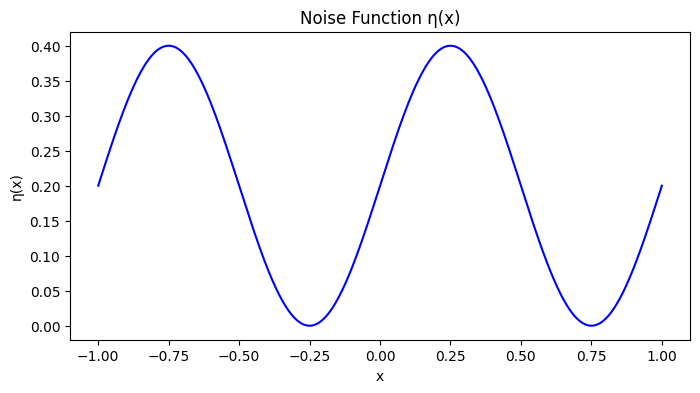

In [3]:
# Plotting eta function
x_vals = np.linspace(-1, 1, 500)
eta_vals = eta_nonLinear(x_vals, eta_max=0.4)
plt.figure(figsize=(8, 4))
plt.plot(x_vals, eta_vals, label='η(x)', color='blue')
plt.title('Noise Function η(x)')
plt.xlabel('x')
plt.ylabel('η(x)')

In [4]:
# Generate data
def generate_data(m: int, d: int, eta_func, eta_max):
    # Generate X uniformly in [-1, 1]^d
    X = np.random.uniform(-1, 1, size=(m, d))
    
    # Identifiability condition: true labels Y=+1
    Y = np.ones(m)
    
    # Noise
    eta_true = eta_func(X[:,0], eta_max)
    
    # Generate corrupted labels Z
    Z = np.zeros(m,  dtype=np.int_)
    for i in range(m):
        # Flip label with probability η(X_i)
        if np.random.rand() < eta_true[i]:
            Z[i] = -Y[i]  # Flip
        else:
            Z[i] = Y[i]   # Keep
    
    return X, Y, Z, eta_true

In [5]:
# Test
eta_max=0.4
m = 500
d = 1

X, Y, Z, eta_true = generate_data(m, d, eta_linear, eta_max)

print(f"Generated {m} samples in dimension d={d}")
print(f"X shape: {X.shape}")
print(f"Y values: {np.unique(Y)} (counts: {np.bincount(((Y + 1)//2).astype(int))})")
print(f"Z values: {np.unique(Z)} (counts: {np.bincount(((Z + 1)//2).astype(int))})")
print(f"Empirical flip rate: {np.mean(Y != Z):.3f}")
print(f"True average η: {np.mean(eta_true):.3f}")


Generated 500 samples in dimension d=1
X shape: (500, 1)
Y values: [1.] (counts: [  0 500])
Z values: [-1  1] (counts: [131 369])
Empirical flip rate: 0.262
True average η: 0.240


## 2. Implement the estimator of η that you proposed.

In [6]:
def gaussian_kernel (u):
    """
    Symmetrical Gaussian kernel function
    u: vector in R^d
    """
    return np.exp(-0.5 * np.dot(u, u)) / (2 * np.pi)**(len(u)/2)


In [7]:
def eta_estimator(X,Z,x,h):
    "Nadaraya-Watson estimator of eta at point x"
    
    eta_tilde = 0.0
    denominator = 0.0

    for i in range(len(X)):
        u = (X[i] - x) / h
        K = gaussian_kernel(u)
        eta_tilde += (1-Z[i])*K
        denominator += K
    if denominator == 0:
        return 0.0

    eta_tilde = eta_tilde/(2*denominator)
    return(eta_tilde)


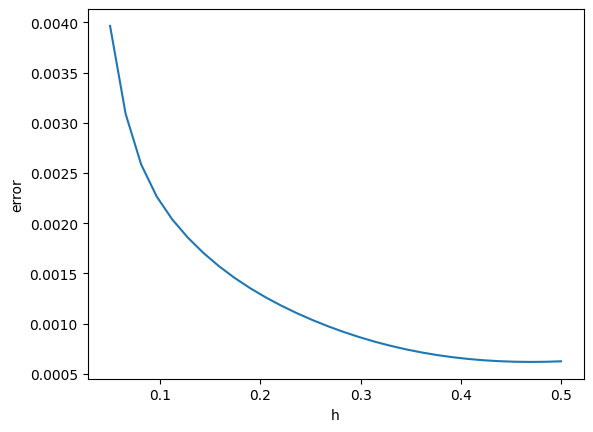

In [8]:
# Cross-validation to chose h
def cross_validation(eta,X,Z,h):
    error = 0
    n = X.shape[0]

    for i in range(X.shape[0]):
        # Leave-one-out
        cross_X = np.delete(X,i,0)
        cross_Z = np.delete(Z,i,0)

        eta_hat_i = eta_estimator(cross_X,cross_Z,X[i],h)
        error+= (eta[i] - eta_hat_i)**2
    
    return(error/n)

#hs = np.linspace(1, 2, 30)
hs = np.linspace(0.05, 0.5, 30)
errs = [cross_validation(eta_true,X, Z, h) for h in hs]

plt.plot(hs, errs)
plt.xlabel("h")
plt.ylabel("error")
plt.show()


    

- Small h → high variance, noisy estimator
- Large h → more smoothing, lower variance

In [9]:
# Select optimal h
h_opt = hs[np.argmin(errs)]
print("Optimal h:", h_opt)

Optimal h: 0.4689655172413793


In [10]:
def h_optimal(X,Z,eta_true,a,b,nbr_pas):
    optimal_h = 0
    min_error = np.inf
    for h in  np.linspace(a,b,nbr_pas):
        error = cross_validation(eta_true,X,Z,h)
        if error < min_error :
                optimal_h = h
                min_error = error
    return(optimal_h)


h_opt = h_optimal(X,Z,eta_true,0.05,0.5,30)
print("Optimal h:", h_opt)

Optimal h: 0.4689655172413793


Estimated value of eta [np.float64(0.22069407112795295), np.float64(0.2551305002952766), np.float64(0.3135173871990486), np.float64(0.2905253707644804), np.float64(0.3033681501583736), np.float64(0.2768477247228471), np.float64(0.28316106682863673), np.float64(0.31004854474507854), np.float64(0.2224797685669086), np.float64(0.246321577829538), np.float64(0.2215089252930113), np.float64(0.32751374672386135), np.float64(0.32274176887312683), np.float64(0.2202876257286436), np.float64(0.28563829630277293), np.float64(0.32047497638511), np.float64(0.22061987255189805), np.float64(0.25980090501334335), np.float64(0.31924939097740934), np.float64(0.2203163033605858), np.float64(0.28412178464882515), np.float64(0.2248833159120589), np.float64(0.32036931783528044), np.float64(0.3257754978501933), np.float64(0.3227660309048872), np.float64(0.24395803358438864), np.float64(0.31194824878041993), np.float64(0.3093481934950771), np.float64(0.2263424039839074), np.float64(0.30694095012597133), np.fl

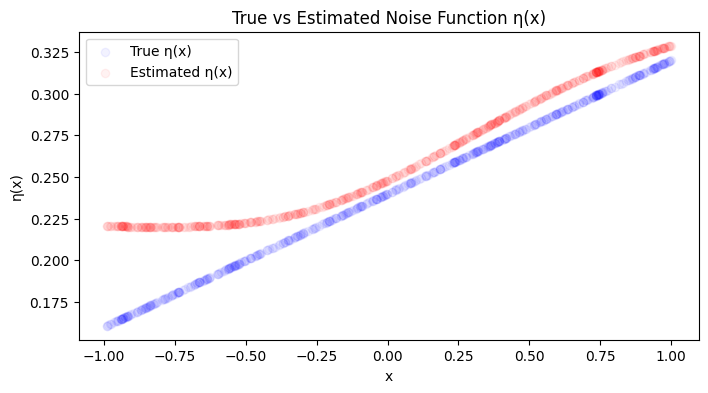

In [11]:
X_test, Y_test, Z_test, eta_true = generate_data(m,d,eta_linear,eta_max)
estimated_eta = []
for x in X_test :
    estimated_eta.append(eta_estimator(X,Z,x,h_opt))

print(f"Estimated value of eta {estimated_eta}")
print(f"Real value of eta : {eta_true}")

# Plot estimated vs true eta
plt.figure(figsize=(8, 4))
plt.scatter(X_test[:,0], eta_true, label='True η(x)', color='blue', alpha=0.05)
plt.scatter(X_test[:,0], estimated_eta, label='Estimated η(x)', color='red', alpha=0.05)
plt.title('True vs Estimated Noise Function η(x)')
plt.xlabel('x')
plt.ylabel('η(x)')
plt.legend()
plt.show()


## 3. Illustrate empirically its performance (estimation error, influence of the sample size m, the dimension d, and the noise level).

In [12]:
result_estimator = np.array(estimated_eta)

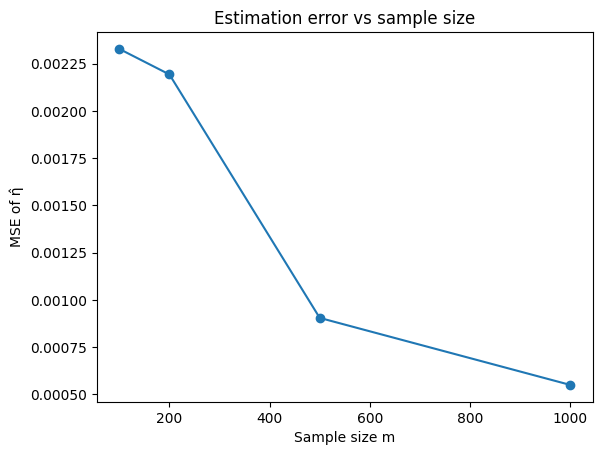

In [65]:
#Estimation error 
def MSE(eta,eta_hat):
    return np.mean((eta - eta_hat)**2)

# à voir si on garde cette partie parce que elle est un peu redondante avec le plot suivant

def mse_eta(m, h): 
    mc_repetitions = 30 # For staibility while averaging
    vals = []
    for _ in range(mc_repetitions):
        X, Y, Z, _ = generate_data(m, d, eta_linear, eta_max)

        x_grid = np.linspace(-1, 1, 200)
        eta_est = np.array([eta_estimator(X, Z, np.array([x]), h) for x in x_grid])

        eta_real = eta_linear(x_grid, eta_max)
        vals.append(MSE(eta_real, eta_est))
    return np.mean(vals)


sample_sizes = [100, 200, 500, 1000]
mse_values = [mse_eta_mc(m, h_opt) for m in sample_sizes]

# Plot MSE vs sample size

plt.figure()
plt.plot(sample_sizes, mse_values, marker='o')
plt.xlabel("Sample size m")
plt.ylabel("MSE of η̂")
plt.title("Estimation error vs sample size")
plt.show()


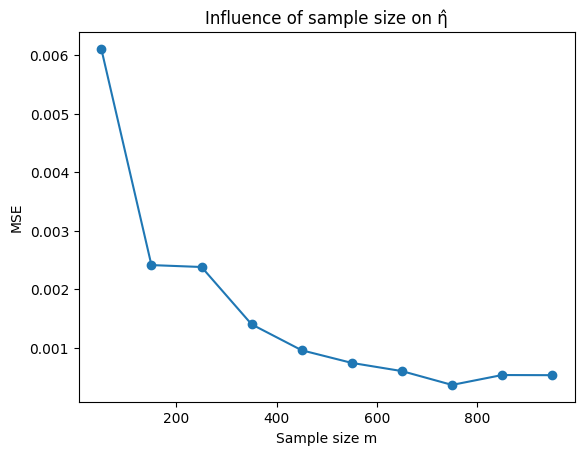

In [41]:
#Influence of the sample size m (takes some time to run because of h_optimal in the loop)

m_values=np.array([50 + i*100 for i in range(10)])
n_rep = 20   # number of repetitions for averaging and having a good estimate of MSE
mse_means = []

for m in m_values:
    mse_rep = []
    # Average over repetitions
    for _ in range(n_rep):
        X, Y, Z, eta_true= generate_data(m, d, eta_linear, eta_max)
        X_test, Y_test, Z_test, eta_true_test = generate_data(50, d, eta_linear, eta_max)
        h = 0.43  # or CV (long to compute )
        data_estimation_values = np.array([eta_estimator(X, Z, x, h) for x in X_test])
        mse_rep.append(MSE(eta_true_test, data_estimation_values))
    mse_means.append(np.mean(mse_rep))

plt.figure()
plt.plot(m_values, mse_means, marker='o')
plt.xlabel("Sample size m")
plt.ylabel("MSE")
plt.title("Influence of sample size on η̂")
plt.show()



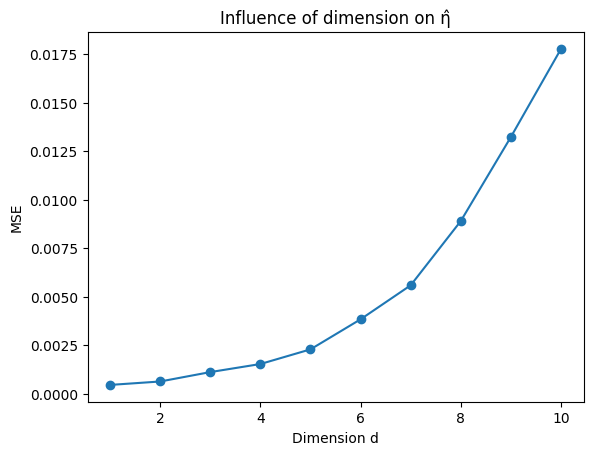

In [69]:
#Influence of the sample size d
d_values = np.arange(1, 11)
m = 1000
n_rep = 30

data_points = []

for dimension in d_values:
    mse_rep_dim = []
    for _ in range(n_rep):
    
        X, Y, Z, eta_true = generate_data(m, dimension, eta_linear, eta_max)
        X_test, Y_test, Z_test, eta_true_test = generate_data(50, dimension, eta_linear, eta_max)
        h=h_opt
        data_estimation_values = np.array([eta_estimator(X, Z, x, h) for x in X_test])
        mse_rep_dim.append(MSE(eta_true_test, data_estimation_values))

    data_points.append(np.mean(mse_rep_dim))



plt.figure()
plt.plot(d_values, data_points, marker='o')
plt.xlabel("Dimension d")
plt.ylabel("MSE")
plt.title("Influence of dimension on η̂")
plt.show()







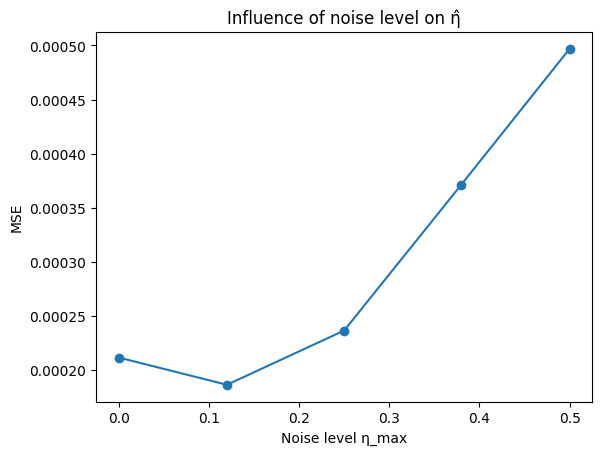

In [68]:
#Influence of noise level
eta_values = np.round(np.linspace(0, 0.5, 5), 2)
n_rep = 30
m = 500
d=1

data_points = []

for eta_max_curr in eta_values:
    mse_rep_eta = []
    for _ in range(n_rep):
        X, Y, Z, eta_true = generate_data(m, d, eta_linear, eta_max_curr)
        X_test, Y_test, Z_test, eta_true_test = generate_data(50, d, eta_linear, eta_max_curr)
        
        h = h_opt

        data_estimation_values = np.array([eta_estimator(X, Z, x, h) for x in X_test])
        mse_rep_eta.append(MSE(eta_true_test, data_estimation_values))
        
    data_points.append(np.mean(mse_rep_eta))


plt.figure()
plt.plot(eta_values, data_points, marker='o')
plt.xlabel("Noise level η_max")
plt.ylabel("MSE")
plt.title("Influence of noise level on η̂")
plt.show()

